# Environmental setup

In [1]:
# %load ~/python/my_import.py
# BASIC
import numpy as np
import xarray as xr
import pandas as pd

#xr.set_options(display_style="text") # make it look better when posted online. Comment to get nicer representation of xarrays
import os
os.environ['HDF5_PLUGIN_PATH'] = '/work/bm0021/conda-envs/eerie_io/lib/python3.11/site-packages/hdf5plugin/plugins'

# matplotlib
import matplotlib
#%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.tri as mtri
import matplotlib.dates as md
import matplotlib.patches as patches
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from matplotlib import ticker
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['axes.linewidth'] = 1.5

## color
from matplotlib import cm
import cmocean
import seaborn as sns

## cartopy
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point


# scipy
from scipy import stats
from scipy import optimize
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
from scipy.stats import binned_statistic
import scipy.spatial.qhull as qhull


# metpy
import metpy
import metpy.calc as mpcalc


# etc
import subprocess
import time
import datetime
from datetime import timedelta
import calendar


# Dask
import dask # Distributed data libary
from dask import delayed
from dask import compute
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
from dask.utils import format_bytes
from distributed import Client, progress # Libaray to orchestrate distributed resources
from dask.distributed import Client
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

from pathlib import Path
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths
from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
import warnings
warnings.filterwarnings(action='ignore')

from matplotlib.dates import DateFormatter

In [ ]:
# Set some user specific variables
account_name = 'mh0731' # Account that is going to be 'charged' fore the computation
queue = 'compute' # Name of the partition we want to use
# queue = 'gpu' # Name of the partition we want to use
#queue = 'shared' # Name of the partition we want to use
job_name = 'PostProc' # Job name that is submitted via sbatch
memory = "500GiB" # Max memory per node that is going to be used - this depends on the partition
cores = 16 # Max number of cores per task that are reserved - also partition dependend
walltime = '4:00:00' # Walltime - also partition dependent

scratch_dir = Path('/scratch') / getuser()[0] / getuser() # Define the users scratch dir
# Create a temp directory where the output of distributed cluster will be written to, after this notebook
# is closed the temp directory will be closed
dask_tmp_dir = TemporaryDirectory(dir=scratch_dir, prefix=job_name)
cluster = SLURMCluster(memory=memory,
                       cores=cores,
                       project=account_name,
                       walltime=walltime,
                       queue=queue,
                       name=job_name,
                       scheduler_options={'dashboard_address': ':12435'},
                       local_directory=dask_tmp_dir.name,
                       job_extra=[f'-J {job_name}', 
                                  f'-D {dask_tmp_dir.name}',
                                  f'--begin=now',
                                  f'--output={dask_tmp_dir.name}/LOG_cluster.%j.o',
                                  f'--output={dask_tmp_dir.name}/LOG_cluster.%j.o'
                                 ],
                       interface='ib0')

cluster.scale(jobs=1)
cluster

dask_client = Client(cluster)
dask_client

In [2]:
def cut_region(model_lon, model_lat, elements, box):
    """
    Return mesh elements (triangles) and their indices corresponding to a bounding box.
    Parameters
    ----------
    model_lon : 1d numpy array
        longitudes of mesh vertices
    model_lat : 1d numpy array
        latitudes of mesh vertices
    box : list
        Coordinates of the box in [-180 180 -90 90] format.
    Returns
    -------
    elem_no_nan : array
        elements that belong to the region defined by the `box`.
    no_nan_triangles: array
        boolean array of element size with True for elements
        that belong to the `box`.
    """
    left, right, down, up = box

    selection = (
        (model_lon >= left)
        & (model_lon <= right)
        & (model_lat >= down)
        & (model_lat <= up)
    )

    elem_selection = selection[elements]

    no_nan_triangles = np.all(elem_selection, axis=1)

    elem_no_nan = elements[no_nan_triangles]

    return elem_no_nan, no_nan_triangles

def get_no_cyclic(model_lon, model_lat, elem_no_nan):
    """Compute non cyclic elements of the mesh."""
    d = model_lon[elem_no_nan].max(axis=1) - model_lon[elem_no_nan].min(axis=1)
    no_cyclic_elem = np.argwhere(d < 100)
    return no_cyclic_elem.ravel()


def extract_1d(in_xr, ncells):
    raw_data = in_xr.isel(ncells=ncells).values[:-1]
    if start_year != 2021:
        raw_data = np.concatenate( (np.zeros( raw_data.shape[1] ), raw_data) )
    
    yearly    = np.zeros((end_year + 4 - start_year))
    yearly[:] = np.NaN
    
    for ith_cycle in np.arange((end_year + 4 - start_year)/4):
        idx_raw = int(ith_cycle) * 1461
        idx     = int(ith_cycle) * 4
        
        yearly[idx  ] = np.mean(raw_data[idx_raw+365*0:idx_raw+365*1])
        yearly[idx+1] = np.mean(raw_data[idx_raw+365*1:idx_raw+365*2])
        yearly[idx+2] = np.mean(raw_data[idx_raw+365*2:idx_raw+365*3])
        yearly[idx+3] = np.mean(raw_data[idx_raw+365*3:idx_raw+365*4+1])
        
    cyclely    = np.zeros(( int((end_year + 4 - start_year)/4)))
    cyclely[:] = np.NaN
    
    for ith_cycle in np.arange((end_year + 4 - start_year)/4):
        idx_raw = int(ith_cycle) * 1461
        
        cyclely[int(ith_cycle)] = np.mean(raw_data[idx_raw:idx_raw+1461])

    return raw_data, yearly, cyclely


def extract_2d(in_xr, middle=False):
    
    raw_data = in_xr.values[:-1,:]
    if start_year != 2021 or middle:
        raw_data = np.concatenate( (np.zeros( (1,raw_data.shape[1]) ), raw_data), axis=0)
    
    yearly    = np.zeros((end_year + 4 - start_year, raw_data.shape[1]))
    yearly[:] = np.NaN
    
    for ith_cycle in np.arange((end_year + 4 - start_year)/4):
        idx_raw = int(ith_cycle) * 1461
        idx     = int(ith_cycle) * 4
        
        yearly[idx  ,:] = np.mean(raw_data[idx_raw+365*0:idx_raw+365*1,:], axis=0)
        yearly[idx+1,:] = np.mean(raw_data[idx_raw+365*1:idx_raw+365*2,:], axis=0)
        yearly[idx+2,:] = np.mean(raw_data[idx_raw+365*2:idx_raw+365*3,:], axis=0)
        yearly[idx+3,:] = np.mean(raw_data[idx_raw+365*3:idx_raw+365*4+1,:], axis=0)
        
    cyclely    = np.zeros(( int((end_year + 4 - start_year)/4), raw_data.shape[1]))
    cyclely[:] = np.NaN
    
    for ith_cycle in np.arange((end_year + 4 - start_year)/4):
        idx_raw = int(ith_cycle) * 1461
        
        cyclely[int(ith_cycle),:] = np.mean(raw_data[idx_raw:idx_raw+1461,:], axis=0)

    return raw_data, yearly, cyclely

In [3]:
molC_to_g     = 12.01
molC_to_kg    = 12.01 * 1.e-3
molCO2_to_g   = 44.01
molCO2_to_gg  = 44.01 * 1.e-3
sec_per_day   = 86400.
days_per_year = 365.

convert_unit = molC_to_g * sec_per_day * days_per_year

# data

In [4]:
resolution = 'R2B9'

In [5]:
dpath = '/work/mh0731/m300793/Carbon/grid-generator/grids/'

if resolution == 'R2B4':
    gridICON = xr.open_mfdataset(f'{dpath}/icon_grid_0043_R02B04_EU.nc')
elif resolution == 'R2B6':
    gridICON = xr.open_mfdataset(f'{dpath}/icon_grid_0021_R02B06_EU.nc')
elif resolution == 'R2B9':
    gridICON = xr.open_mfdataset(f'{dpath}/icon_grid_0015_R02B09_EU.nc')
else:
    raise Exception("Select R2B4, R2B6, or R2B9")
    
gridICON

<xarray.Dataset>
Dimensions:                         (cell: 279900, nv: 3, vertex: 146946,
                                     edge: 428899, no: 4, nc: 2, ne: 6,
                                     max_chdom: 1, cell_grf: 14, edge_grf: 24,
                                     vert_grf: 13)
Coordinates:
    clon                            (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    clat                            (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    vlon                            (vertex) float64 dask.array<chunksize=(146946,), meta=np.ndarray>
    vlat                            (vertex) float64 dask.array<chunksize=(146946,), meta=np.ndarray>
    elon                            (edge) float64 dask.array<chunksize=(428899,), meta=np.ndarray>
    elat                            (edge) float64 dask.array<chunksize=(428899,), meta=np.ndarray>
Dimensions without coordinates: cell, nv, vertex, edge, no, nc, ne, max_chdom,
                                cell_grf, edge_grf, vert_grf
Data variables: (12/79)
    clon_vertices                   (cell, nv) float64 dask.array<chunksize=(279900, 3), meta=np.ndarray>
    clat_vertices                   (cell, nv) float64 dask.array<chunksize=(279900, 3), meta=np.ndarray>
    elon_vertices                   (edge, no) float64 dask.array<chunksize=(428899, 4), meta=np.ndarray>
    elat_vertices                   (edge, no) float64 dask.array<chunksize=(428899, 4), meta=np.ndarray>
    cell_area                       (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    dual_area                       (vertex) float64 dask.array<chunksize=(146946,), meta=np.ndarray>
    ...                              ...
    edge_dual_normal_cartesian_x    (edge) float64 dask.array<chunksize=(428899,), meta=np.ndarray>
    edge_dual_normal_cartesian_y    (edge) float64 dask.array<chunksize=(428899,), meta=np.ndarray>
    edge_dual_normal_cartesian_z    (edge) float64 dask.array<chunksize=(428899,), meta=np.ndarray>
    cell_circumcenter_cartesian_x   (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    cell_circumcenter_cartesian_y   (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
    cell_circumcenter_cartesian_z   (cell) float64 dask.array<chunksize=(279900,), meta=np.ndarray>
Attributes: (12/34)
    title:                    ICON grid description
    institution:              Max Planck Institute for Meteorology/Deutscher ...
    source:                   git@gitlab.dkrz.de:mpim-sw/grid-generator.git
    revision:                 af7c06e8f469272b80158baabf60568c59888b9d
    history:                  /work/mh0731/m300793/Carbon/grid-generator/bin/...
    date:                     20240205 at 202058
    ...                       ...
    mean_cell_area:           24323517.809282698
    mean_dual_cell_area:      48647026.33989711
    domain_length:            40031612.44147649
    domain_height:            40031612.44147649
    sphere_radius:            6371229.0
    domain_cartesian_center:  [0. 0. 0.]

In [6]:
vlon, vlat = gridICON['vlon'].values*180./np.pi, gridICON['vlat'].values*180./np.pi
clon, clat = gridICON['clon'].values*180./np.pi, gridICON['clat'].values*180./np.pi
elements   = gridICON.vertex_of_cell[:,:].T.values-1

### Open function

In [19]:
def get_data(grid, expname, dpath, start_year, end_year, time_init='2021-01-01', is_cold_start=True, ):
    
    dataICON_basic_list = []
    
    if (start_year == 2021) & (is_cold_start):
        dataICON_basic1 = xr.open_mfdataset(f'{dpath}/2021-????/*_jsbalone_{grid}_{expname}_lnd_basic_ml_*Z.nc')
        dataICON_basic_list.append(dataICON_basic1)
        start_year2 = start_year + 4
    else:
        start_year2 = start_year
        
    for yyyy in np.arange(start_year2, end_year+4, 4):
        dataICON_basic1 = xr.open_mfdataset(f'{dpath}/{yyyy}-????/*_jsbalone_{grid}_{expname}_lnd_basic_ml_*Z.nc')
        dataICON_basic1['time'] = dataICON_basic1['time'] + (yyyy-2021)*10000
        dataICON_basic_list.append(dataICON_basic1)
        
    dataICON_basic_output = xr.concat(dataICON_basic_list, dim='time')
    dataICON_basic_output['time'] = xr.cftime_range(start=time_init, periods=len(dataICON_basic_output['time']), freq="1D")

    return dataICON_basic_output

### Read data

In [15]:
if resolution == 'R2B4':
    id, grid, expname, is_cold_start = 'e40', resolution, 'EU', True
    start_year, end_year = 2021, 2201
elif resolution == 'R2B6':
    id, grid, expname, is_cold_start = 'e60', resolution, 'EU', False
    start_year, end_year = 2025, 2221
elif resolution == 'R2B9':
    id, grid, expname, is_cold_start = 'e90', resolution, 'EU', False
    start_year, end_year = 2021, 2037

# if resolution == 'R2B4':
#     id, grid, expname, is_cold_start = '51', resolution, 'EURO-CORDEX', True
#     start_year, end_year = 2021, 2233
# elif resolution == 'R2B6':
#     id, grid, expname, is_cold_start = '62', resolution, 'germany', False
#     start_year, end_year = 2021, 2149
# elif resolution == 'R2B9':
#     id, grid, expname, is_cold_start = '72', resolution, 'germany', False
#     start_year, end_year = 2021, 2257

In [ ]:
# dpath = f'/work/mh0731/m300793/Carbon/1jsb-hr-std/experiments/{id}_jsbalone_{grid}_{expname}/'
# dataICON_basic1 = xr.open_mfdataset(f'{dpath}/2029-2032/e90_jsbalone_R2B9_EU_lnd_basic_ml_20210101T000000Z.nc_wrong')
# dataICON_basic1
# dataICON_basic1.isel(time=slice(17, 382)).to_netcdf(f'{dpath}/2029-2032/e90_jsbalone_R2B9_EU_lnd_basic_ml_20210101T000000Z.nc_corrected', mode='w')

In [16]:
dpath = f'/work/mh0731/m300793/Carbon/1jsb-hr-std/experiments/{id}_jsbalone_{grid}_{expname}/'
# dpath = f'/work/mh0731/m300793/JSBACH/1jsb-hr-std/experiments/{id}_jsbalone_{grid}_{expname}/'

dataICON_basic = get_data(grid, expname, dpath, start_year, end_year, time_init='2021-01-01', is_cold_start=is_cold_start)
dataICON_basic

2021
2025
2029
2033
2037


<xarray.Dataset>
Dimensions:                             (time: 7305, ncells: 279900,
                                         vertices: 3, soil_depth_energy: 5,
                                         bnds: 2, snow_depth_energy: 5,
                                         soil_depth_water: 5)
Coordinates:
  * time                                (time) object 2021-01-01 00:00:00 ......
    clon                                (ncells) float32 0.01745 ... 0.4093
    clat                                (ncells) float32 0.9182 ... 0.8338
  * soil_depth_energy                   (soil_depth_energy) float64 0.0325 .....
  * snow_depth_energy                   (snow_depth_energy) float64 0.025 ......
  * soil_depth_water                    (soil_depth_water) float64 0.0325 ......
Dimensions without coordinates: ncells, vertices, bnds
Data variables: (12/262)
    clon_bnds                           (time, ncells, vertices) float32 dask.array<chunksize=(364, 279900, 3), meta=np.ndarray>
    clat_bnds                           (time, ncells, vertices) float32 dask.array<chunksize=(364, 279900, 3), meta=np.ndarray>
    soil_depth_energy_bnds              (time, soil_depth_energy, bnds) float64 dask.array<chunksize=(364, 5, 2), meta=np.ndarray>
    snow_depth_energy_bnds              (time, snow_depth_energy, bnds) float64 dask.array<chunksize=(364, 5, 2), meta=np.ndarray>
    soil_depth_water_bnds               (time, soil_depth_water, bnds) float64 dask.array<chunksize=(364, 5, 2), meta=np.ndarray>
    a2l_DEBUG_VAR_box                   (time, ncells) float32 dask.array<chunksize=(364, 279900), meta=np.ndarray>
    ...                                  ...
    carbon_co2_l2a_npp_ta_veg           (time, ncells) float32 dask.array<chunksize=(364, 279900), meta=np.ndarray>
    carbon_co2_l2a_resp_ta_veg          (time, ncells) float32 dask.array<chunksize=(364, 279900), meta=np.ndarray>
    carbon_co2_l2a_herb_ta_veg          (time, ncells) float32 dask.array<chunksize=(364, 279900), meta=np.ndarray>
    carbon_ccons_calccpools_veg         (time, ncells) float32 dask.array<chunksize=(364, 279900), meta=np.ndarray>
    fuel_fuel_box                       (time, ncells) float32 dask.array<chunksize=(364, 279900), meta=np.ndarray>
    fuel_fuel_veg                       (time, ncells) float32 dask.array<chunksize=(364, 279900), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.4 (http://mpimet...
    Conventions:          CF-1.6
    number_of_grid_used:  42
    uuidOfHGrid:          b1106b54-c45b-11ee-8367-4fb6911d3de6
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               git@gitlab.dkrz.de:icon/icon-mpim.git@a6d9c7bfa1d5c...
    history:              /work/mh0731/m300793/Carbon/1jsb-hr-std/bin/icon at...
    references:           see MPIM/DWD publications
    comment:              Junhong Lee (m300793) on l10300 (Linux 4.18.0-425.1...

# NEE + Spin-up check

In [33]:
NEE = dataICON_basic['carbon_npp_pot_ydaymean_ta_box'] + dataICON_basic['carbon_soil_respiration_ta_box']
NEE = NEE.mean('ncells').resample(time='4Y').mean().compute() * convert_unit
del_NEE      = NEE.diff('time')
del_NEE_time = del_NEE['time']
del_NEE_data = del_NEE/4.

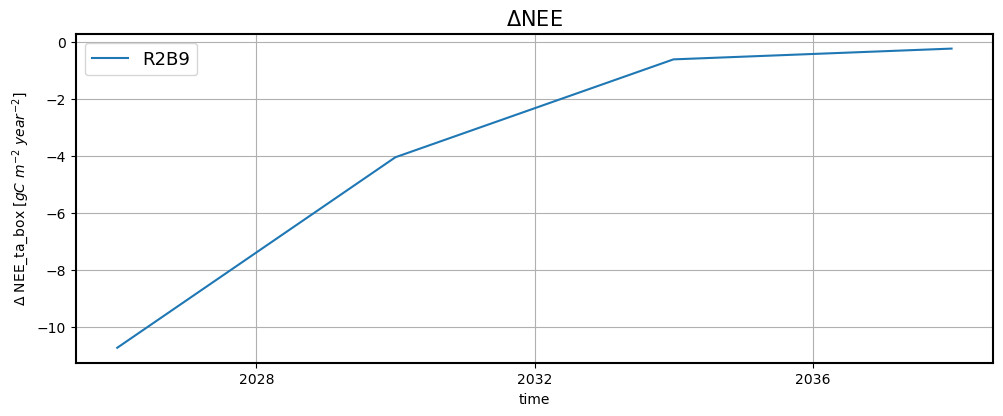

In [34]:
rmax, cmax = 2, 2
fig, ax = plt.subplots(nrows=rmax,ncols=cmax, figsize=(20, 8),)

rr, cc = 0, 0
# ax[rr,cc].plot(del_NEE_time[:-1], np.abs(del_NEE_data/4.)[:-1], label=str(resolution))
del_NEE_data.isel(time=slice(0,-1)).plot(ax=ax[rr,cc], label=str(resolution))

ax[rr,cc].set_ylabel('$\Delta$ NEE_ta_box $[g C \ m^{-2} \ year^{-2}]$')
ax[rr,cc].set_title('$\Delta$NEE', size=15)
ax[rr,cc].grid()
leg=ax[rr,cc].legend(prop={'size': 13})

plt.tight_layout()

rr, cc = 0, 1
ax[rr,cc].set_visible(False)
rr, cc = 1, 0
ax[rr,cc].set_visible(False)
rr, cc = 1, 1
ax[rr,cc].set_visible(False)

### Spin-up check

In [39]:
NEE_2d = dataICON_basic['carbon_npp_pot_ydaymean_ta_box'] + dataICON_basic['carbon_soil_respiration_ta_box']
NEE_2d = NEE_2d.resample(time='4Y').mean().compute() * convert_unit
del_NEE_2d = NEE_2d.diff('time')/4.
num_NEE_2d = xr.where( (del_NEE_2d>1.) | (del_NEE_2d<-1.), 1, 0)
per_NEE_2d = num_NEE_2d / dataICON_basic['ncells'].size

spinup_date = del_NEE_time.where( num_NEE_2d.sum('ncells')==0, drop=True ).squeeze().values

Spin-up is not done yet


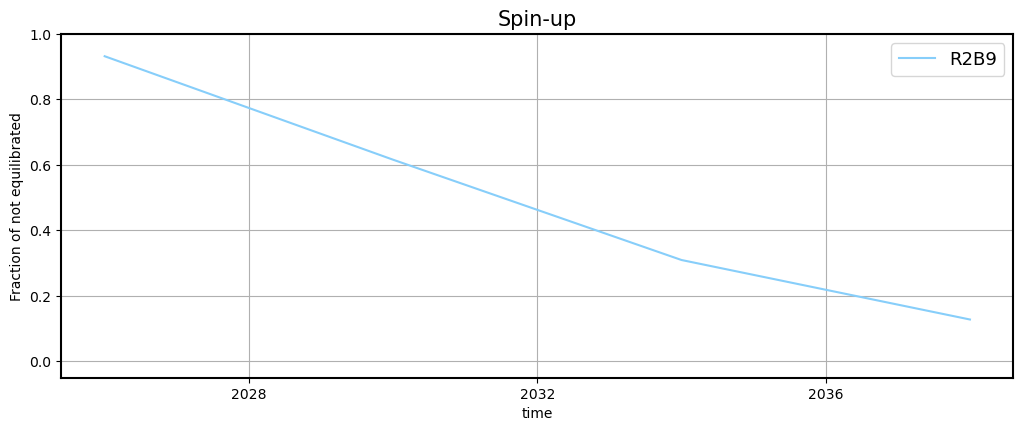

In [40]:
rmax, cmax = 2, 2
fig, ax = plt.subplots(nrows=rmax,ncols=cmax, figsize=(20, 8),)

rr, cc = 0, 0
per_NEE_2d.sum('ncells').isel(time=slice(0,-1)).plot(ax=ax[rr,cc], c='lightskyblue', label=str(resolution))

if len(spinup_date) != 0:
    # ax[rr,cc].scatter(spinup_date[0], 0, c='lightskyblue', s=50)
    print("Spin-up is done at the year of :", spinup_date[0])
    
else:
    print("Spin-up is not done yet")

ax[rr,cc].set_ylabel('Fraction of not equilibrated')
ax[rr,cc].set_ylim(-0.05, 1.0)
ax[rr,cc].set_title('Spin-up', size=15)
ax[rr,cc].grid()
leg=ax[rr,cc].legend(prop={'size': 13})

plt.tight_layout()

rr, cc = 0, 1
ax[rr,cc].set_visible(False)
rr, cc = 1, 0
ax[rr,cc].set_visible(False)
rr, cc = 1, 1
ax[rr,cc].set_visible(False)

plt.tight_layout()

In [15]:
spinup_date

array([], dtype=object)

# Map plot

In [42]:
def get_map_plot_data(plot_data, elements, lon, lat, box):

    data_to_plot_raw = plot_data.values
    elem_no_nan, no_nan_triangles = cut_region(lon, lat, elements, box)
    no_cyclic_elem2 = get_no_cyclic(lon, lat, elem_no_nan)
    data_to_plot = data_to_plot_raw[no_nan_triangles][no_cyclic_elem2]
    elem_to_plot = elem_no_nan[no_cyclic_elem2]
    
    return data_to_plot, elem_to_plot, data_to_plot_raw

def plot_2d_map (ax, data_to_plot, elem_to_plot, lon, lat, box, title=None, cmap=cm.viridis, clabel=None, **kwargs):

    ax.coastlines(resolution='110m', color='k')
    ax.add_feature(cfeature.BORDERS, zorder=10, edgecolor='black', facecolor='white')

    ax.set_extent(box, crs=ccrs.PlateCarree())
    img = ax.tripcolor(lon, lat, elem_to_plot, data_to_plot, transform=ccrs.PlateCarree(),
                       cmap=cmap, lw=0.1, **kwargs)
                    #    edgecolors='face', cmap=cmap, lw=0.1, **kwargs)

    # cbar = plt.colorbar(img, orientation='vertical', fraction=0.02, pad=0.03, ax=ax)
    # cbar.set_label(clabel)
    ax.set_title(title)


    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(4.5)

    return img

In [43]:
box = [-15, 38, 32, 75]
plot_num, elem, elevation_2d_raw = get_map_plot_data(num_NEE_2d[-2,:], elements, vlon, vlat, box=box)

In [44]:
plot_num

array([0, 0, 0, ..., 0, 1, 0])

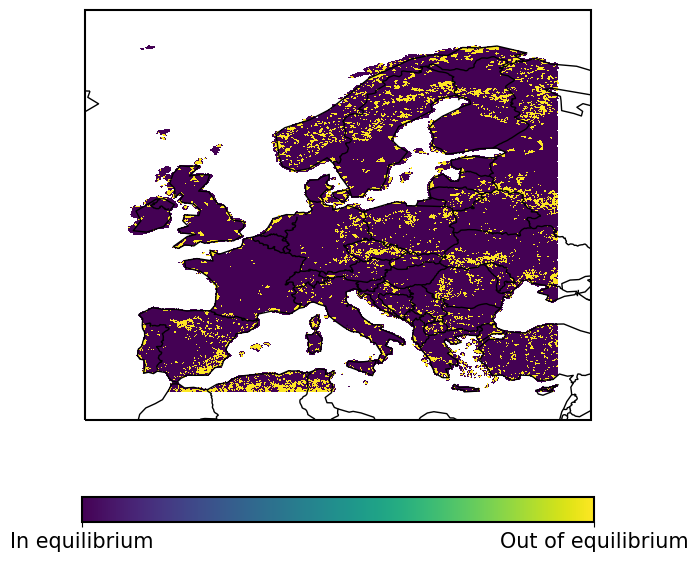

In [50]:
rmax, cmax = 2, 2
fig, ax = plt.subplots(nrows=rmax, ncols=cmax, figsize=(13, 11), subplot_kw={'projection': ccrs.PlateCarree()},)

rr, cc = 0, 0
img = plot_2d_map(ax[rr,cc], plot_num, elem, vlon, vlat, box=box, cmap=cm.viridis, )

cbar = plt.colorbar(img, orientation='horizontal', fraction=0.050, pad=0.15, ax=ax[rr,cc])
cbar.set_ticks([0,1])
cbar.set_ticklabels(["In equilibrium", "Out of equilibrium"],fontsize=15)
# cbar.set_label('correlation coefficient', fontsize=15)

rr, cc = 0, 1
ax[rr,cc].set_visible(False)
rr, cc = 1, 0
ax[rr,cc].set_visible(False)
rr, cc = 1, 1
ax[rr,cc].set_visible(False)
plt.tight_layout()